In [82]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [84]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [88]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        outputs = [input]
        for i in range(len(self.modules)):
            outputs.append(self.modules[i].forward(outputs[-1]))
        current_grad = gradOutput
        for i in range(len(self.modules)-1, -1, -1):
            current_grad = self.modules[i].backward(outputs[i], current_grad)
        self.gradInput = current_grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [90]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW += gradOutput.T @ input
        self.gradb += gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [92]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        norm_input = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = np.exp(norm_input) / np.exp(norm_input).sum(axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        batch_size = input.shape[0]
        gradInput = np.zeros_like(input)
        for i in range(batch_size):
            softmax_output = self.output[i].reshape(-1, 1)
            grad_output = gradOutput[i].reshape(-1, 1)
            jacobian = np.diagflat(softmax_output) - softmax_output @ softmax_output.T
            gradInput[i] = (jacobian @ grad_output).flatten()
        self.gradInput = gradInput
        return self.gradInput
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [94]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        norm_input = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = norm_input - np.log(np.exp(norm_input).sum(axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        self.gradInput = gradOutput - np.exp(self.output) * gradOutput.sum(axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [96]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0, ddof=0)
            self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
            if self.moving_mean is None:
                self.moving_mean = batch_mean
                self.moving_variance = batch_variance
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * batch_mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * batch_variance
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_variance = np.var(input, axis=0)
            sigma = np.sqrt(batch_variance + self.EPS)
            m = input.shape[0]  # batch size
            mean_grad = np.mean(gradOutput, axis=0)
            covar_grad = np.mean(gradOutput * (input - batch_mean), axis=0) / (sigma**2)
            self.gradInput = (gradOutput - mean_grad - (input - batch_mean) * covar_grad) / sigma
            self.gradGamma = np.sum((input - batch_mean) * gradOutput / sigma, axis=0)
            self.gradBeta = np.sum(gradOutput, axis=0)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [98]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [100]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p).astype(float)
            self.output = input * self.mask / (1 - self.p)
        else:
            self.output = input
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask / (1 - self.p)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [102]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        if padding == 'same':
          self.padding = (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[1] - 1) / 2))
        else:
          self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.bias_TF = bias
        self.padding_mode = padding_mode

        self.weight = np.random.randn(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        self.gradW = np.zeros_like(self.weight)
        if self.bias_TF:
          self.bias = np.random.randn(out_channels)
          self.gradb = np.zeros_like(self.bias)

        if self.padding_mode=='zeros':
          self.mode='constant'
          self.constant_values=0
        elif self.padding_mode=='replicate':
          self.mode='edge'
        elif self.padding_mode=='reflect':
          self.mode='reflect'
    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        H_in, W_in = input.shape[2], input.shape[3]
        H_out = int((H_in + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0]) + 1
        W_out = int((W_in + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1]) + 1
        self.output = np.zeros((batch_size, self.out_channels, H_out, W_out))

        pad_config = ((0, 0), (0, 0), (self.padding[0], self.padding[0]), (self.padding[1], self.padding[1]))
        if self.mode == 'constant':
            self.input_pad = np.pad(input, pad_config, mode=self.mode, constant_values=self.constant_values)
        else:
            self.input_pad = np.pad(input, pad_config, mode=self.mode)

        for n in range(batch_size):
            for c in range(self.out_channels):
                for h in range(H_out):
                    h_start = h * self.stride[0]
                    for w in range(W_out):
                        w_start = w * self.stride[1]
                        field = self.input_pad[n, :, h_start:h_start+self.kernel_size[0], 
                                             w_start:w_start+self.kernel_size[1]]
                        self.output[n, c, h, w] = np.sum(field * self.weight[c])
                if self.bias_TF:
                    self.output[n, c] += self.bias[c]
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        H_in, W_in = input.shape[2], input.shape[3]
        _, _, H_out, W_out = gradOutput.shape
        self.gradInput = np.zeros_like(input)
        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h_out in range(H_out):
                    h_start = h_out * self.stride[0]
                    for w_out in range(W_out):
                        w_start = w_out * self.stride[1]
                        for c_in in range(self.in_channels):
                            for h_k in range(self.kernel_size[0]):
                                h_in = h_start + h_k - self.padding[0]
                                for w_k in range(self.kernel_size[1]):
                                    w_in = w_start + w_k - self.padding[1]
                                    if 0 <= h_in < H_in and 0 <= w_in < W_in:
                                        self.gradInput[n, c_in, h_in, w_in] += (
                                            gradOutput[n, c_out, h_out, w_out] * 
                                            self.weight[c_out, c_in, h_k, w_k]
                                        )
                                    else:
                                        if self.mode == 'edge':
                                            h_clip = max(0, min(h_in, H_in - 1))
                                            w_clip = max(0, min(w_in, W_in - 1))
                                            self.gradInput[n, c_in, h_clip, w_clip] += (
                                                gradOutput[n, c_out, h_out, w_out] * 
                                                self.weight[c_out, c_in, h_k, w_k]
                                            )
                                        elif self.mode == 'reflect':
                                            h_ref = h_in
                                            if h_in < 0: h_ref = -h_in
                                            elif h_in >= H_in: h_ref = 2 * H_in - h_in - 2
                                            w_ref = w_in
                                            if w_in < 0: w_ref = -w_in
                                            elif w_in >= W_in: w_ref = 2 * W_in - w_in - 2
                                            self.gradInput[n, c_in, h_ref, w_ref] += (
                                                gradOutput[n, c_out, h_out, w_out] * 
                                                self.weight[c_out, c_in, h_k, w_k]
                                            )
        
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        H_in, W_in = input.shape[-2:]
        batch_size, C_out, H_out, W_out = gradOutput.shape

        self.gradInput = np.zeros_like(input)

        for n in range(batch_size):
          for c_out in range(self.out_channels):
            for h_out in range(H_out):
              for w_out in range(W_out):
                h_start = h_out * self.stride[0]
                w_start = w_out * self.stride[1]

                receptive_field = self.input_pad[n, :, h_start:(h_start + self.kernel_size[0]), w_start: (w_start+ self.kernel_size[1])]

                self.gradW[c_out] += receptive_field * gradOutput[n, c_out, h_out, w_out]
                if self.bias_TF:
                  self.gradb[c_out] += gradOutput[n, c_out, h_out, w_out]
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        if self.bias_TF:
          self.gradb.fill(0)

    def getParameters(self):
        if self.bias_TF:
          return [self.weight, self.bias]
        else: return [self.weight]

    def getGradParameters(self):
        if self.bias_TF:
          return [self.gradW, self.gradb]
        else: return [self.gradW]

    def __repr__(self):
        return "Conv2d"

# 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [104]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, in_channels, in_height, in_width = input.shape
        kernel_size = self.kernel_size if isinstance(self.kernel_size, tuple) else (self.kernel_size, self.kernel_size)
        stride = self.stride if isinstance(self.stride, tuple) else (self.stride, self.stride)
        padding = self.padding if isinstance(self.padding, tuple) else (self.padding, self.padding)
        out_height = (in_height + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
        out_width = (in_width + 2 * padding[1] - kernel_size[1]) // stride[1] + 1
        self.output = np.zeros((batch_size, in_channels, out_height, out_width))
        self.indices = np.zeros((batch_size, in_channels, out_height, out_width, 2), dtype=int)
        input_padded = np.pad(input, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), mode='constant', constant_values=-np.inf)
    
        for b in range(batch_size):
            for c in range(in_channels):
                for oh in range(out_height):
                    for ow in range(out_width):
                        h_start = oh * stride[0]
                        h_end = h_start + kernel_size[0]
                        w_start = ow * stride[1]
                        w_end = w_start + kernel_size[1]
                        receptive_field = input_padded[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, oh, ow] = np.max(receptive_field)
                        max_index = np.unravel_index(np.argmax(receptive_field), receptive_field.shape)
                        self.indices[b, c, oh, ow] = [h_start + max_index[0], w_start + max_index[1]]
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, in_channels, in_height, in_width = input.shape
        kernel_size = self.kernel_size if isinstance(self.kernel_size, tuple) else (self.kernel_size, self.kernel_size)
        stride = self.stride if isinstance(self.stride, tuple) else (self.stride, self.stride)
        padding = self.padding if isinstance(self.padding, tuple) else (self.padding, self.padding)
        self.gradInput = np.zeros_like(input)

        for b in range(batch_size):
            for c in range(in_channels):
                for oh in range(gradOutput.shape[2]):
                    for ow in range(gradOutput.shape[3]):
                        h, w = self.indices[b, c, oh, ow]
                        self.gradInput[b, c, h, w] += gradOutput[b, c, oh, ow]
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding

    def updateOutput(self, input):
        batch_size, channels, in_h, in_w = input.shape
        out_h = (in_h + 2*self.padding[0] - self.kernel_size[0]) // self.stride[0] + 1
        out_w = (in_w + 2*self.padding[1] - self.kernel_size[1]) // self.stride[1] + 1
        if any(self.padding):
            pad_h, pad_w = self.padding
            padded_input = np.pad(input, 
                               ((0,0), (0,0),
                               (pad_h, pad_h),
                               (pad_w, pad_w)))
        else:
            padded_input = input
        self.output = np.empty((batch_size, channels, out_h, out_w))
        for n in range(batch_size):
            for c in range(channels):
                for h in range(out_h):
                    h_start = h * self.stride[0]
                    for w in range(out_w):
                        w_start = w * self.stride[1]
                        window = padded_input[n, c, 
                                            h_start:h_start+self.kernel_size[0],
                                            w_start:w_start+self.kernel_size[1]]
                        self.output[n, c, h, w] = window.mean()
                        
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        batch_size, channels, out_h, out_w = gradOutput.shape
        in_h, in_w = input.shape[2:]
        kernel_area = self.kernel_size[0] * self.kernel_size[1]
        self.gradInput = np.zeros_like(input)
        for n in range(batch_size):
            for c in range(channels):
                for h_out in range(out_h):
                    h_in = h_out * self.stride[0] - self.padding[0]
                    for w_out in range(out_w):
                        w_in = w_out * self.stride[1] - self.padding[1]
                        grad = gradOutput[n, c, h_out, w_out] / kernel_area
                        for h_k in range(self.kernel_size[0]):
                            for w_k in range(self.kernel_size[1]):
                                hi = h_in + h_k
                                wi = w_in + w_k
                                if 0 <= hi < in_h and 0 <= wi < in_w:
                                    self.gradInput[n, c, hi, wi] += grad
                                    
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

# 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**.
They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [106]:
class GlobalMaxPool2d(Module):
    def __init__(self, keepdims):
        super(GlobalMaxPool2d, self).__init__()
        self.keepdims = keepdims

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, C, H, W = input.shape
        self.output = np.max(input, axis=(2, 3))
        input_1 = input.reshape(batch_size, C, -1)
        self.max_indices = np.argmax(input_1, axis=2)
        if self.keepdims:
          self.output = self.output.reshape((batch_size, C, 1, 1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, C = gradOutput.shape[:2]
        H, W = input.shape[-2:]
        self.gradInput = np.zeros_like(input)
        if self.keepdims:
            gradOutput = gradOutput.reshape(batch_size, C)
        max_h = self.max_indices // W
        max_w = self.max_indices % W
        batch, channel = np.indices((batch_size, C))
        self.gradInput[batch, channel, max_h, max_w] = gradOutput
        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"


class GlobalAvgPool2d(Module):
    def __init__(self, keepdims):
        super(GlobalAvgPool2d, self).__init__()

        self.keepdims = keepdims

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch_size, C, H, W = input.shape
        self.output = np.average(input, axis=(2, 3))
        if self.keepdims:
          self.output = self.output.reshape((batch_size, C, 1, 1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch_size, C = gradOutput.shape[:2]
        H, W = input.shape[-2:]
        n_pix = H*W
        self.gradInput = np.zeros_like(input)
        if self.keepdims:
            gradOutput = gradOutput.reshape(batch_size, C)
        for n in range(batch_size):
            for c in range(C):
              self.gradInput[n, c] = gradOutput[n,c] / n_pix
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

# 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [108]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        input_shape = input.shape
        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(input_shape) + self.end_dim
        preserved_dims = input_shape[:start_dim]
        flattened_dims = input_shape[start_dim:end_dim+1]
        remaining_dims = input_shape[end_dim+1:] if end_dim+1 < len(input_shape) else ()
        flattened_size = 1
        for dim in flattened_dims:
            flattened_size *= dim
        output_shape = preserved_dims + (flattened_size,) + remaining_dims
        self.in_shape = input_shape
        self.output = input.reshape(output_shape)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.in_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [111]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [113]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [115]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [117]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log1p(np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = (1.0 / (1.0 + np.exp(-input))) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [119]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = 0.5 * input * (1 + np.tanh((2 / np.pi)**0.5 * (input + 0.044715 * input**3)))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ###############################################
        x = input
        sqrt_2_pi = np.sqrt(2 / np.pi)
        alpha = 0.044715
        
        x_cubed = x**3
        r = sqrt_2_pi * (x + alpha * x_cubed)
        tanh_r = np.tanh(r)
        dtanh_dr = 1 - tanh_r**2
        dr_dx = sqrt_2_pi * (1 + 3 * alpha * x**2)
        dtanh_dx = dtanh_dr * dr_dx
        gelu_grad = 0.5 * (1 + tanh_r) + 0.5 * x * dtanh_dx
        self.gradInput = gradOutput * gelu_grad
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [121]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [123]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [125]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        log_probs = -np.log(input_clamp)
        batch_losses = np.sum(log_probs * target, axis=1)
        total_loss = np.sum(batch_losses)
        batch_size = input.shape[0]
        self.output = total_loss / batch_size
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        batch_size = input.shape[0]
        grad = -target / input_clamp
        self.gradInput = grad / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [127]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        batch_scores = np.sum(input * target, axis=1)
        batch_size = input.shape[0]
        total_loss = -np.sum(batch_scores)
        self.output = total_loss / batch_size
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        self.gradInput = -target / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [129]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import accuracy_score, r2_score

Немного переопределю связочный слой

In [131]:
class Sequential_upd(Module):

    def __init__(self):
        super(Sequential_upd, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        current_output = input
        if not self.modules:
            self.output = current_output
            return self.output
        for module in self.modules:
            current_output = module.forward(current_output)
        self.output = current_output
        return self.output

    def backward(self, input, gradOutput):
        # Your code goes here. ################################################
        current_grad = gradOutput
        if not self.modules:
            self.gradInput = current_grad
            return self.gradInput
        for i in range(len(self.modules) - 1, -1, -1):
            module = self.modules[i]
            input_for_backward = input if i == 0 else self.modules[i - 1].output
            current_grad = module.backward(input_for_backward, current_grad)
        self.gradInput = current_grad
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        params = []
        for module in self.modules:
            module_params = module.getParameters()
            if module_params:
                params.extend(module_params)
        return params

    def getGradParameters(self):
        grad_params = []
        for module in self.modules:
            module_grad_params = module.getGradParameters()
            if module_grad_params:  # Проверяем, что список не пустой
                grad_params.extend(module_grad_params)
        return grad_params

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

    def __repr__(self):
        string = "Sequential_upd (\n"
        for i, module in enumerate(self.modules):
            module_str = str(module)
            indented_module_str = "  " + module_str.replace("\n", "\n  ")
            if indented_module_str.endswith("\n  "):
                indented_module_str = indented_module_str[:-2]
            string += f"  ({i}): {indented_module_str}\n"
        string += ")"
        return string

    def __getitem__(self, x):
        return self.modules.__getitem__(x)

### 1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами.

In [133]:
class SGD:
    def __init__(self, model_params, lr=1e-3, wd=0):
        self.model_params = model_params
        self.lr = lr
        self.wd = wd  # L2 регуляризация

    def step(self, gradients):
        for param, grad in zip(self.model_params, gradients):
            if param is None or grad is None:
                continue
            if (self.wd > 0 and param.ndim > 1):
                grad = grad + self.wd * param
            update = self.lr * grad
            if param.dtype != grad.dtype:
                update = update.astype(param.dtype)
            param -= update

    def zero_grad(self, model):
        model.zeroGradParameters()

#### Шедулер

In [135]:
class StepLR:
    def __init__(self, optim, step_size, gamma=0.1):
        self.optim = optim
        self.step_size = step_size
        self.gamma = gamma
        self.epoch = 0
    def step(self):
        self.epoch += 1
        if self.epoch % self.step_size == 0:
            self.optim.lr = self.optim.lr * self.gamma

#### Напишем некоторые вспомогательные функции

In [137]:
def accuracy(y_true, y_pred): 
    return accuracy_score(y_true, y_pred)

def r2(y_pred, y_true):
    return r2_score(y_true, y_pred)

def batcing(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

#### Функция для обучения и валидации модели

In [139]:
def train(model, criterion, optimizer, scheduler=None, X_train=None, y_train=None,
          X_val=None, y_val=None, epochs=10, batch_size=32, metric_func=None, mode="classification"):

    train_loss_history, val_loss_history, train_metric_history, val_metric_history = [], [], [], []


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_metric = 0.0
        train_samples = 0

        for X_batch, y_batch in batcing(X_train, y_train, batch_size):
            optimizer.zero_grad(model)
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            grad = criterion.backward(y_pred, y_batch)
            model.backward(X_batch, grad)
            optimizer.step(model.getGradParameters())

            train_loss += loss * X_batch.shape[0]
            
            if metric_func:
                y_pred_proc = np.argmax(y_pred, axis=-1) if mode == "classification" else y_pred
                metric = metric_func(y_batch, y_pred_proc)
                train_metric += metric * X_batch.shape[0]
            
            train_samples += X_batch.shape[0]

        model.evaluate()
        val_loss = 0.0
        val_metric = 0.0
        val_samples = 0

        for X_batch, y_batch in batcing(X_val, y_val, batch_size):
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            val_loss += loss * X_batch.shape[0]
            
            if metric_func:
                y_pred_proc = np.argmax(y_pred, axis=-1) if mode == "classification" else y_pred
                metric = metric_func(y_batch, y_pred_proc)
                val_metric += metric * X_batch.shape[0]
            
            val_samples += X_batch.shape[0]

        avg_train_loss = train_loss / train_samples
        avg_val_loss = val_loss / val_samples
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        if metric_func:
            avg_train_metric = train_metric / train_samples
            avg_val_metric = val_metric / val_samples
            train_metric_history.append(avg_train_metric)
            val_metric_history.append(avg_val_metric)

        lr = optimizer.lr
        if scheduler:
            scheduler.step()
            new_lr = optimizer.lr
            lr_changed = new_lr != lr
        else:
            lr_changed = False

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}", end="")
        
        if metric_func:
            print(f"| Train {str(metric)}: {avg_train_metric:.4f}| "
                  f"Val {str(metric)}: {avg_val_metric:.4f}", end="")
            print()


    return (train_loss_history, val_loss_history, train_metric_history, val_metric_history)

### 2. Модель мультирегресии
Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель.

#### 2.1 Генерируем данные для мультирегресии

In [141]:
W_true = np.random.randn(3, 5).astype(np.float32) * 2
b_true = np.random.randn(3).astype(np.float32) * 5
X = np.random.rand(10000, 5).astype(np.float32) * 10

y = (X @ W_true.T + b_true + np.random.randn(10000, 3).astype(np.float32) * 0.5).astype(np.float32)

#### 2.2 Подготовка данных

In [143]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 2.3 Модель для регрессии

In [145]:
def create_regression_model(n_features, n_targets, hidden_size, n_layers, activation=None, dropout_mode=0.0):
    model = Sequential_upd()
    last_size = n_features
    for i in range(n_layers):
        model.add(Linear(last_size, hidden_size))
        model.add(BatchNormalization())
        model.add(ChannelwiseScaling(hidden_size))
        model.add(activation())
        if dropout_mode > 0:
            model.add(Dropout(dropout_mode))
        last_size = hidden_size
    model.add(Linear(last_size, n_targets))
    return model

#### 2.4 Создаём модели (маленькую, среднюю и большую) 

In [147]:
model_small = create_regression_model(n_features=5, n_targets=3, hidden_size=32, n_layers=1, activation=ReLU, dropout_mode=0.1)
model_medium = create_regression_model(n_features=5, n_targets=3, hidden_size=64, n_layers=2, activation=ELU, dropout_mode=0.2)
model_large = create_regression_model(n_features=5, n_targets=3, hidden_size=128, n_layers=3, activation=Gelu, dropout_mode=0.3)

#### 2.5 Обучение модели (только маленькой, остальные - аналогично)

In [149]:
criterion = MSECriterion()
optimizer = SGD(model_small.getParameters(), 1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

train_loss, val_loss, train_metric, val_metric = train(model_small, criterion, optimizer, scheduler, X_train, y_train,
                                                       X_val, y_val, epochs=50, batch_size=32, metric_func=r2, mode="reg")

Epoch 1/50: Train Loss: 494.6732 | Val Loss: 110.4759| Train 0.46577150407143436: -40859.9137| Val 0.46577150407143436: 0.3488
Epoch 2/50: Train Loss: 86.0776 | Val Loss: 22.5822| Train 0.9160977003841749: 0.7254| Val 0.9160977003841749: 0.9139
Epoch 3/50: Train Loss: 71.7146 | Val Loss: 22.8094| Train 0.892968766596205: 0.8007| Val 0.892968766596205: 0.9066
Epoch 4/50: Train Loss: 66.0826 | Val Loss: 23.1388| Train 0.9032374335988371: 0.8165| Val 0.9032374335988371: 0.9054
Epoch 5/50: Train Loss: 62.0966 | Val Loss: 23.4065| Train 0.9410051750454104: 0.8309| Val 0.9410051750454104: 0.9412
Epoch 6/50: Train Loss: 61.1537 | Val Loss: 55.9502| Train 0.8399379233728163: 0.8326| Val 0.8399379233728163: 0.8867
Epoch 7/50: Train Loss: 55.6463 | Val Loss: 13.5647| Train 0.9695718098701717: 0.8487| Val 0.9695718098701717: 0.9654
Epoch 8/50: Train Loss: 53.5592 | Val Loss: 49.7808| Train 0.8857031157389454: 0.8551| Val 0.8857031157389454: 0.8798
Epoch 9/50: Train Loss: 51.7355 | Val Loss: 9.182

#### 2.6 Отрисовка трейнов

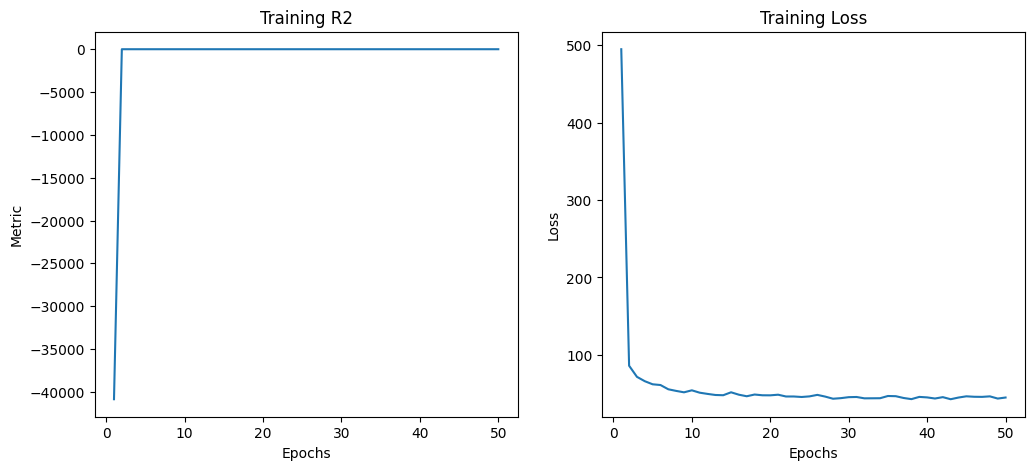

In [150]:
epochs = range(1, len(train_metric) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_metric, label="Training")
plt.title("Training R2")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Training")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

### 3. Модель мультиклассификации
Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы

#### 3.1 Вытаскиваем данные MINT

In [151]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_val = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test = MNIST(root="./data", train=False, download=True, transform=ToTensor())

#### 3.2 Подготовка данных

In [152]:
X = train_val.data.numpy().astype(np.float32) / 255.0
y = train_val.targets.numpy()
X_test = test.data.numpy().astype(np.float32) / 255.0
y_test = test.targets.numpy()
X = X[:, None, :, :]
X_test = X_test[:, None, :, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#### 3.3 Модель для классификации

In [153]:
def create_classification_model():
    model = Sequential_upd()
    model.add(Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=1))
    model.add(Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2, stride=2, padding=1))
    model.add(Flatten())
    model.add(Linear(n_in=16 * 7 * 7, n_out=128))
    model.add(ReLU())
    model.add(Dropout(0.25))
    model.add(Linear(n_in=128, n_out=10))
    model.add(SoftMax())
    return model

#### 3.4 Создём модель

In [154]:
model = create_classification_model()

#### 3.5 Обучение модели

In [79]:
# criterion = MSECriterion()
# optimizer = SGD(model.getParameters(), lr=1e-3)
# train_loss, val_loss, train_metric, val_metric = train(model, criterion, optimizer, X_train, y_train, X_val, y_val,
#                                                        epochs=1, batch_size=128, metric_func=accuracy, mode="classification")

i'm done